# Sparkify Project Workspace - Predictive Modeling

This notebook explores how different customer characteristics affect the probability of churning from a music streaming subscription.

In [1]:
# import libraries
from itertools import chain
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import re
import gc
import pyspark
from pyspark.sql.types import IntegerType, StringType, DoubleType, LongType
from pyspark.sql.window import Window
from pyspark.sql.functions import  desc, explode, lit, split, udf, count, avg, col, concat\
,mean,when,lead,isnan,countDistinct,month,from_unixtime,datediff,to_timestamp
import pyspark.sql.functions as F
import pyspark.sql.context 
from pyspark import SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

%matplotlib inline
import matplotlib.pyplot as plt
gc.collect()

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20210104234026-0000
KERNEL_ID = 0fe4cde4-91a1-4495-ab89-eb9d80d98783


4

In [2]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.ap-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-73262c01-6ac2-45a3-8128-50f462a3d828',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'A1hDyHu7cqIIXIKH4femE9WnyBlukXMkoBeWfb4DZCqm'
}

configuration_name = 'os_878688b9464f4f5e93f45a4ed3683f7f_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Part 1: Load and Clean Dataset

## 1.1 Loading the Dataset 

In [3]:
df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkifychurnprediction-donotdelete-pr-gh0yoxzekm7cww'))
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## 1.2 Cleaning the Data

In [4]:
# Filter out the rows with blank User IDs
df = df.filter(df['userId']!='')

In [5]:
# Final User ID count
df.select('userId').distinct().count()

448

In [6]:
# Final Session ID count
df.select('sessionId').distinct().count()

4470

In [7]:
# Convert the UNIX millisecond timestamp to datetime
to_date = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0) \
             .strftime("%Y-%m-%d"))

df = df.withColumn('ts_date', to_date('ts'))
df = df.withColumn('ts_registration', to_date('registration'))

# Part 2: Exploratory Data Analysis
This part explores the dataset for patterns before jumping into feature engineering and modeling.

## 2.1 Define Churn

In [8]:
# Users who cancelled subscription
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn_event', churn_event('page'))

In [9]:
# Users who downgraded
downgrade_event = udf(lambda x: 1 if x == 'Downgrade' else 0, IntegerType())
df = df.withColumn('downgrade_event', downgrade_event('page'))

## 2.2 Explore Data

In [10]:
# Create a user-level dataset with userId and churn / downgrade markers
df_user = df.groupBy('userId').agg({'churn_event':'max', 'downgrade_event':'max'}) \
            .withColumnRenamed('max(churn_event)', 'churn') \
            .withColumnRenamed('max(downgrade_event)', 'downgrade') 

df_user.count()

448

### 2.2.1 Initial Data Exploration
Join some existing fields into the user dataset, and add some features that we can explore by churn status.

In [11]:
df.select('userId','gender','location').distinct()

DataFrame[userId: string, gender: string, location: string]

In [12]:
# Join Gender & Location data to user data
df_demogs = df.select('userId','gender','location','level').distinct()
df_user = df_user.join(df_demogs, on='userId')

# Part 3: Feature Engineering
Some features that can possibly affect churn rates can be derived from the dataset. Here are some of the features that I think will be good predictors:

### Candidate Features:

1. Total sessions in a week
2. Total number of songs listened to
3. Total number of artists listened to
4. Number of thumbs up
5. Number of thumbs down
6. Number of friend requests sent
7. Number of add to playlist
8. Number of songs played in a session
9. Average session length
10. Average Gap (number of days) in between visit
11. Days from registration date

In [13]:
# Number of songs listened to
song_count = df.groupBy('userId').agg(countDistinct('song')).withColumnRenamed('count(DISTINCT song)','song_count')
# Number of artists listened to
artist_count = df.groupBy('userId').agg(countDistinct('artist')).withColumnRenamed('count(DISTINCT artist)','artist_count')

In [14]:
# Function to count number of instances depending on the page action
def count_page(df, condition):
    filter_str = 'page == "' + condition + '"'
    return df.filter(filter_str).groupBy('userId').count()
    
page_thumbsup = count_page(df, 'Thumbs Up').withColumnRenamed('count','thumbsup_count')
page_thumbsdown = count_page(df, 'Thumbs Down').withColumnRenamed('count','thumbsdown_count')
page_addfriend = count_page(df, 'Add Friend').withColumnRenamed('count','addfriend_count')
page_addplaylist = count_page(df, 'Add to Playlist').withColumnRenamed('count','addplaylist_count')
page_error = count_page(df, 'Error').withColumnRenamed('count','pageerror_count')
page_upgrade = count_page(df, 'Upgrade').withColumnRenamed('count','upgrade_count')
page_nextsong = count_page(df, 'NextSong').withColumnRenamed('count','nextsong_count')
page_help = count_page(df, 'Help').withColumnRenamed('count','help_count')
page_rolladvert = count_page(df, 'Roll Advert').withColumnRenamed('count','rolladvert_count')

In [15]:
# Average Session Length
avg_session_length = df.groupBy('userId').mean('length').withColumnRenamed('avg(length)','avg_session_length')

In [16]:
# Total sessions in a week
session_wk = df.groupBy('userId').agg(F.min('ts_date'), F.max('ts_date'), F.countDistinct('sessionId')) \
            .withColumnRenamed('min(ts_date)', 'min_ts_date') \
            .withColumnRenamed('max(ts_date)', 'max_ts_date') \
            .withColumnRenamed('count(DISTINCT sessionId)', 'total_sessions')

def calc_sessions_wk(session_wk, max_date, min_date, all_sessions):
    return F.when(datediff(session_wk[max_date], session_wk[min_date]) == 0, session_wk[all_sessions] / 7) \
    .otherwise((session_wk[all_sessions] / datediff(session_wk[max_date], session_wk[min_date])) * 7)

session_wk = session_wk.withColumn('avg_sessions_wk', calc_sessions_wk(session_wk, 'max_ts_date', 'min_ts_date', 'total_sessions'))

In [17]:
# Calculate visit gap

# For each user, get all the dates that they had any session (ts_date)
user_by_session = df.select('userId', 'ts_date').distinct().sort(['userId', 'ts_date'])
# Use a window function to shift the dates and get the dates for the next session
user_by_session = user_by_session.withColumn('date_next_session',lead('ts_date',1)\
                .over(Window.partitionBy('userId').orderBy('ts_date'))) \
                .filter(F.col('date_next_session').isNotNull())

# Get the average gap per user
user_by_session = user_by_session.withColumn('gap', datediff(F.col('date_next_session'), F.col('ts_date')))
user_by_session = user_by_session.groupBy('userId').mean('gap').withColumnRenamed('avg(gap)', 'avg_session_gap')

In [18]:
# Days from registration date

# For each user, get the max ts_date
user_by_registration = df.select('userId','ts_registration', 'ts_date').distinct().sort('userId',desc('ts_date'))
user_by_registration = user_by_registration.toPandas()
user_by_registration = user_by_registration.drop_duplicates(subset=['userId','ts_registration'], keep='first', inplace=False)
user_by_registration = spark.createDataFrame(user_by_registration)
user_by_registration = user_by_registration.withColumn('days_from_reg', datediff('ts_date','ts_registration'))

In [19]:
# Convert gender and level to int to be used for modeling

# Gender to int
int_gender = udf(lambda x: 1 if x == 'F' else 0, IntegerType())
df_user = df_user.withColumn('int_gender',int_gender('gender'))
gender_int = df_user.groupBy('userId').agg(F.max('int_gender')).withColumnRenamed('max(int_gender)','gender')

# Level to int
int_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
df = df.withColumn('int_level',int_level('level'))
level_int = df.groupBy('userId').agg(F.max('int_level')).withColumnRenamed('max(int_level)','level')

### Merging everything into one Spark dataframe for modeling:

In [20]:
# Create a new user_df only including the userId and all relevant features for modeling
df_user = df_user.select(['userId','churn','downgrade']) 

In [21]:
# Merge all the features
df_user = df_user.join(gender_int, 'userId') \
.join(level_int, 'userId') \
.join(song_count, 'userId') \
.join(artist_count, 'userId') \
.join(page_thumbsup, 'userId') \
.join(page_thumbsdown, 'userId') \
.join(page_addfriend, 'userId') \
.join(page_addplaylist, 'userId') \
.join(page_error, 'userId') \
.join(page_upgrade, 'userId') \
.join(page_nextsong, 'userId') \
.join(page_help, 'userId') \
.join(page_rolladvert, 'userId') \
.join(avg_session_length, 'userId') \
.join(session_wk, 'userId') \
.join(user_by_session, 'userId') \
.join(user_by_registration, 'userId') 

In [22]:
# Drop some of the variables we won't be needing for modeling
columns_to_drop = ['min_ts_date', 'max_ts_date', 'ts_registration', 'ts_date']
df_user = df_user.drop(*columns_to_drop)

In [23]:
df_user.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- song_count: long (nullable = false)
 |-- artist_count: long (nullable = false)
 |-- thumbsup_count: long (nullable = false)
 |-- thumbsdown_count: long (nullable = false)
 |-- addfriend_count: long (nullable = false)
 |-- addplaylist_count: long (nullable = false)
 |-- pageerror_count: long (nullable = false)
 |-- upgrade_count: long (nullable = false)
 |-- nextsong_count: long (nullable = false)
 |-- help_count: long (nullable = false)
 |-- rolladvert_count: long (nullable = false)
 |-- avg_session_length: double (nullable = true)
 |-- total_sessions: long (nullable = false)
 |-- avg_sessions_wk: double (nullable = true)
 |-- avg_session_gap: double (nullable = true)
 |-- days_from_reg: integer (nullable = true)



# Part 4: Modeling

### Split into train and test set

In [24]:
df_user_model = df_user.drop('userId')
features = [col for col in df_user_model.columns if col != 'churn'] 
train, test = df_user_model.randomSplit([0.7, 0.3], seed=13)
train = train.cache()

### Create the model pipeline

In [25]:
def model_pipeline(classifier, params):
    """
    Function to build a model pipeline 
    Input:
    classifier: type of classifier
    params: param grid
    Output:
    ML pipeline model
    """
    assembler = VectorAssembler(inputCols=features, outputCol='features')
    scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=params,
        evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=3,
    )
    return model

### Model 1: Logistic Regression

In [26]:
model1 = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
model1_param = ParamGridBuilder().build()
model_lr = model_pipeline(model1, model1_param)

In [27]:
fit_model_lr = model_lr.fit(train)

In [28]:
pred_lr = fit_model_lr.transform(test)

In [29]:
pred_lr.select("prediction").dropDuplicates().collect()
evaluator_lr = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")

f1_score_lr = evaluator_lr.evaluate(pred_lr, {evaluator_lr.metricName: "f1"})
precision_lr = evaluator_lr.evaluate(pred_lr, {evaluator_lr.metricName: "weightedPrecision"})
recall_lr = evaluator_lr.evaluate(pred_lr, {evaluator_lr.metricName: "weightedRecall"})
accuracy_lr = evaluator_lr.evaluate(pred_lr, {evaluator_lr.metricName: "accuracy"})

print("F1-score using Logistic Regression: {}".format(f1_score_lr))
print("Precision using Logistic Regression: {}".format(precision_lr))
print("Recall using Logistic Regression: {}".format(recall_lr))
print("Accuracy using Logistic Regression: {}".format(accuracy_lr))

F1-score using Logistic Regression: 0.8706151357983382
Precision using Logistic Regression: 0.8694559800664451
Recall using Logistic Regression: 0.872093023255814
Accuracy using Logistic Regression: 0.872093023255814


### Model 2: Random Forest

In [30]:
model2 = RandomForestClassifier(featuresCol="scaled_features", labelCol="churn", seed=13)
model2_param = ParamGridBuilder().build()
model_rf = model_pipeline(model2, model2_param)

In [31]:
fit_model_rf = model_rf.fit(train)

In [32]:
pred_rf = fit_model_rf.transform(test)

In [33]:
pred_rf.select("prediction").dropDuplicates().collect()
evaluator_rf = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")

f1_score_rf = evaluator_rf.evaluate(pred_rf, {evaluator_rf.metricName: "f1"})
precision_rf = evaluator_rf.evaluate(pred_rf, {evaluator_rf.metricName: "weightedPrecision"})
recall_rf = evaluator_rf.evaluate(pred_rf, {evaluator_rf.metricName: "weightedRecall"})
accuracy_rf = evaluator_rf.evaluate(pred_rf, {evaluator_rf.metricName: "accuracy"})

print("F1-score using Random Forest: {}".format(f1_score_rf))
print("Precision using Random Forest: {}".format(precision_rf))
print("Recall using Random Forest: {}".format(recall_rf))
print("Accuracy using Random Forest: {}".format(accuracy_rf))

F1-score using Random Forest: 0.9100181175562089
Precision using Random Forest: 0.9261015911872705
Recall using Random Forest: 0.9186046511627907
Accuracy using Random Forest: 0.9186046511627907


### Model 3: Gradient Boosting Trees (GBT)

In [34]:
model3 = GBTClassifier(featuresCol="scaled_features", labelCol="churn", seed=13)
model3_param = ParamGridBuilder().build()
model_gbt = model_pipeline(model3, model3_param)

In [35]:
fit_model_gbt = model_gbt.fit(train)

In [36]:
pred_gbt = fit_model_gbt.transform(test)

In [37]:
pred_gbt.select("prediction").dropDuplicates().collect()
evaluator_gbt = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")

f1_score_gbt = evaluator_gbt.evaluate(pred_gbt, {evaluator_gbt.metricName: "f1"})
precision_gbt = evaluator_gbt.evaluate(pred_gbt, {evaluator_gbt.metricName: "weightedPrecision"})
recall_gbt = evaluator_gbt.evaluate(pred_gbt, {evaluator_gbt.metricName: "weightedRecall"})
accuracy_gbt = evaluator_gbt.evaluate(pred_gbt, {evaluator_gbt.metricName: "accuracy"})

print("F1-score using Gradient Boosting Trees: {}".format(f1_score_gbt))
print("Precision using Gradient Boosting Trees: {}".format(precision_gbt))
print("Recall using Gradient Boosting Trees: {}".format(recall_gbt))
print("Accuracy using Gradient Boosting Trees: {}".format(accuracy_gbt))

F1-score using Gradient Boosting Trees: 0.9637994605034236
Precision using Gradient Boosting Trees: 0.9665697674418605
Recall using Gradient Boosting Trees: 0.9651162790697674
Accuracy using Gradient Boosting Trees: 0.9651162790697675


### Hyperparameter Tuning

In [63]:
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="churn", seed=13)
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxBins, [32, 50]) \
    .addGrid(gbt.maxIter, [20, 30]) \
    .build()
model_tuned = model_pipeline(gbt, paramGrid_gbt)

In [ ]:
fit_model_tuned = model_tuned.fit(train)                                       
best_model = fit_model_tuned.bestModel
best_model_pred = best_model.transform(test)

In [ ]:
best_model_pred.select("prediction").dropDuplicates().collect()
evaluator_best_model = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")

f1_score_best_model = evaluator_best_model.evaluate(best_model_pred, {evaluator_best_model.metricName: "f1"})
precision_best_model = evaluator_best_model.evaluate(best_model_pred, {evaluator_best_model.metricName: "weightedPrecision"})
recall_best_model = evaluator_best_model.evaluate(best_model_pred, {evaluator_best_model.metricName: "weightedRecall"})
accuracy_best_model = evaluator_best_model.evaluate(best_model_pred, {evaluator_best_model.metricName: "accuracy"})

print("F1-score using Gradient Boosting Trees (Best Model): {}".format(f1_score_best_model))
print("Precision using Gradient Boosting Trees (Best Model): {}".format(precision_best_model))
print("Recall using Gradient Boosting Trees (Best Model): {}".format(recall_best_model))
print("Accuracy using Gradient Boosting Trees (Best Model): {}".format(accuracy_best_model))

F1-score using Gradient Boosting Trees (Best Model): 0.9534883720930233
Precision using Gradient Boosting Trees (Best Model): 0.9534883720930233
Recall using Gradient Boosting Trees (Best Model): 0.9534883720930233
Accuracy using Gradient Boosting Trees (Best Model): 0.9534883720930233


In [72]:
print("MaxIter for the best model: {}".format(fit_model_tuned.bestModel.stages[2]._java_obj.getMaxIter()))
print("MaxBins for the best model: {}".format(fit_model_tuned.bestModel.stages[2]._java_obj.getMaxBins()))

MaxIter for the best model: 30
MaxBins for the best model: 50


In [73]:
# For reference, hyperparameters of original, untuned model:
print("MaxIter for the original model: {}".format(fit_model_gbt.bestModel.stages[2]._java_obj.getMaxIter()))
print("MaxBins for the original model: {}".format(fit_model_gbt.bestModel.stages[2]._java_obj.getMaxBins()))

MaxIter for the original model: 20
MaxBins for the original model: 32


### Feature Importance Ranking

In [67]:
# Extract feature importance vector from the best model
best_model_output = fit_model_gbt.bestModel.stages[2]
best_model_output.featureImportances

SparseVector(19, {0: 0.0089, 1: 0.006, 3: 0.1315, 4: 0.0143, 5: 0.0852, 6: 0.0734, 7: 0.0334, 8: 0.0208, 9: 0.0013, 10: 0.021, 12: 0.0143, 13: 0.019, 14: 0.1081, 15: 0.0926, 16: 0.1225, 17: 0.0623, 18: 0.1853})

In [68]:
# Map the Sparse Vector of Feature Importances with the feature names
attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*pred_gbt
        .schema["features"]
        .metadata["ml_attr"]["attrs"].values())))

feature_imp = [(name, best_model_output.featureImportances[idx])
               for idx, name in attrs
               if best_model_output.featureImportances[idx]]

In [69]:
# Function to sort the list by second item of tuple 
def sort_tuple(tup):  
    tup.sort(key = lambda x: x[1])  
    return tup  

sort_tuple(feature_imp) 

[('pageerror_count', 0.0013114158330340428),
 ('gender', 0.006040030485516162),
 ('downgrade', 0.008865191876222447),
 ('help_count', 0.01432709833386501),
 ('artist_count', 0.014349366605073677),
 ('rolladvert_count', 0.018975067467880528),
 ('addplaylist_count', 0.020818103147375748),
 ('upgrade_count', 0.020979734672464268),
 ('addfriend_count', 0.03344228492214306),
 ('avg_session_gap', 0.062292788842764804),
 ('thumbsdown_count', 0.0733925560744956),
 ('thumbsup_count', 0.08516198652960703),
 ('total_sessions', 0.09264014313448433),
 ('avg_session_length', 0.10807543334907091),
 ('avg_sessions_wk', 0.12254187836259026),
 ('song_count', 0.13152915697171003),
 ('days_from_reg', 0.18525776339170205)]

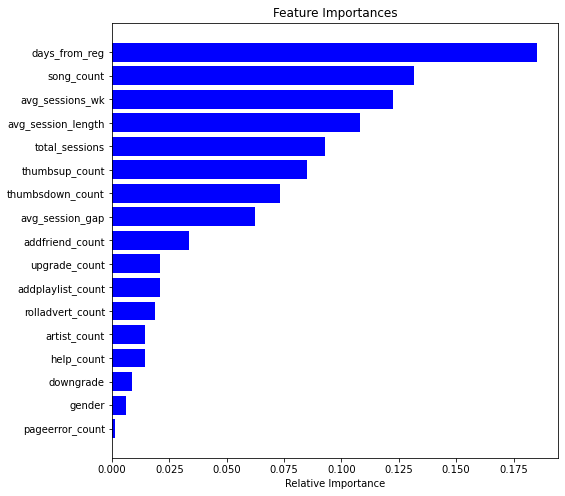

In [70]:
# Plot the Feature Importances
features = [a for (a,b) in feature_imp]
importances = [b for (a,b) in feature_imp]

fig = plt.figure(figsize=(8,8))
plt.title('Feature Importances')
plt.barh(range(len(importances)), importances, color='b', align='center')
plt.yticks(range(len(importances)), features)
plt.xlabel('Relative Importance')
plt.show()

These are the top variables affecting churn:
1. Days from registration (subscription length)
2. Average number of sessions in a week
3. Total songs listened to 
4. Average session length
5. Total sessions logged in 

We explore visually how these metrics vary according to churn status.

In [44]:
# Boxplots with 5 panels for the top 5 variables
def box_plot(df_user,col):
    """
    Prints boxplot of input column
    Input 
    df: spark DataFrame
    ylabel : numeric field that we want as basis for comparison
    Output :
    Plots
    """
    pd = df_user.select('userId','churn',col).toPandas()
    sns.boxplot(x='churn', y=col, data=pd);

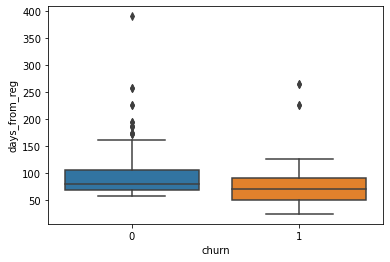

In [45]:
box_plot(df_user, 'days_from_reg')

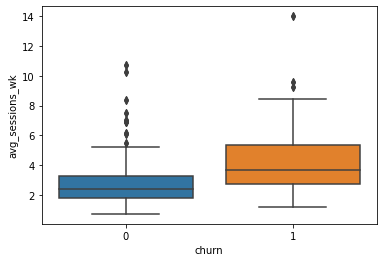

In [46]:
box_plot(df_user, 'avg_sessions_wk')

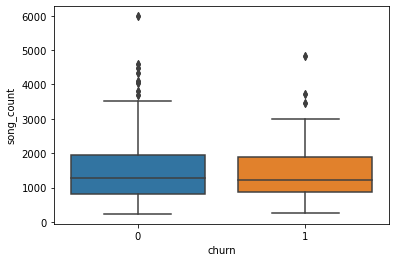

In [47]:
box_plot(df_user, 'song_count')

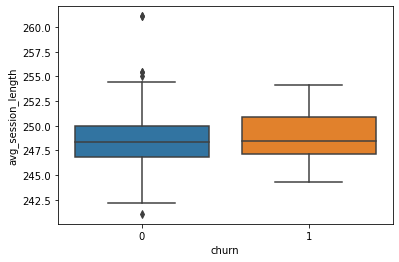

In [48]:
box_plot(df_user, 'avg_session_length')

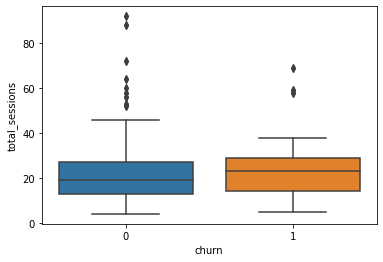

In [49]:
box_plot(df_user, 'total_sessions')

Findings:

Churners are generally more recent subscribers, with the median of around 2 months into their subscription. This is a milestone that can be looked at in terms of providing promos and incentives to prevent them from leaving (i.e. once customers reach 2 months into their subscription offer them freebies and rewards that will entice them to stay).

It shows that churners also tend to log-in more sessions per week, and log-in longer (although there is bigger variation versus non-churners).